In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


C:\Users\Julia\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


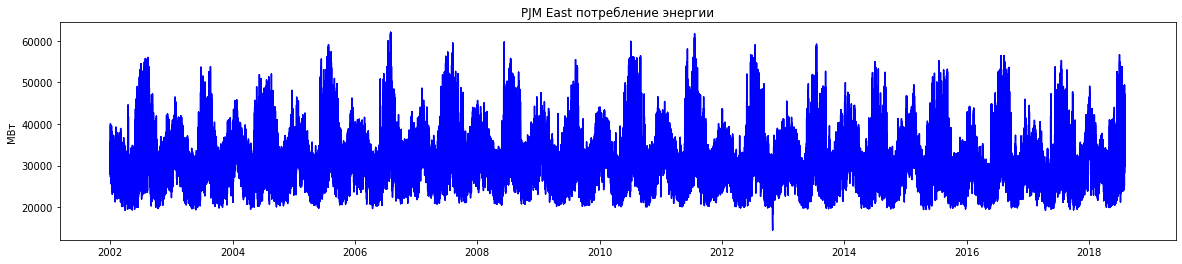

In [3]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [5]:

data_m = data.resample('M').mean()


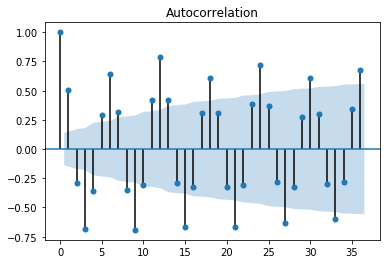

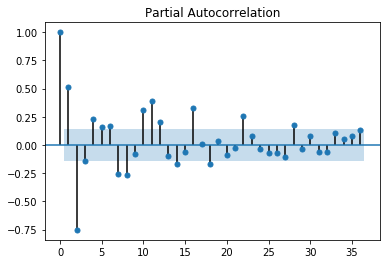

In [6]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=36)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=36)
plt.show()

Берем данные за три года для построения модели.

In [7]:
import warnings

# Определим p, d и q 
q = 2
p = 0
d = 1
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с месячными данными, тогда сезонность это 3 месяцев
qs = 2
ps = 1
ds = 1
seasonal_pdq = [ps, ds, qs ,3] 

In [8]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [0, 1, 2]    : ps,ds,qs, S= [1, 1, 2, 3]


In [9]:
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-36],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results_1 = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results_1.aic))

SARIMAX[0, 1, 2]x[1, 1, 2, 3] - AIC:2717.363085888927


In [10]:
print(results_1.summary().tables[0],results_1.summary().tables[1])

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  164
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 3)   Log Likelihood               -1352.682
Date:                           Thu, 23 Jan 2020   AIC                           2717.363
Time:                                   11:46:13   BIC                           2735.467
Sample:                                        0   HQIC                          2724.718
                                           - 164                                         
Covariance Type:                             opg                                         
========================================================================================= ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

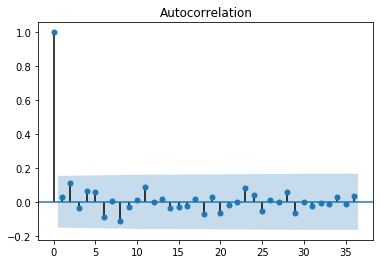

In [11]:
sm.graphics.tsa.plot_acf(results_1.resid, lags=36)
plt.show()

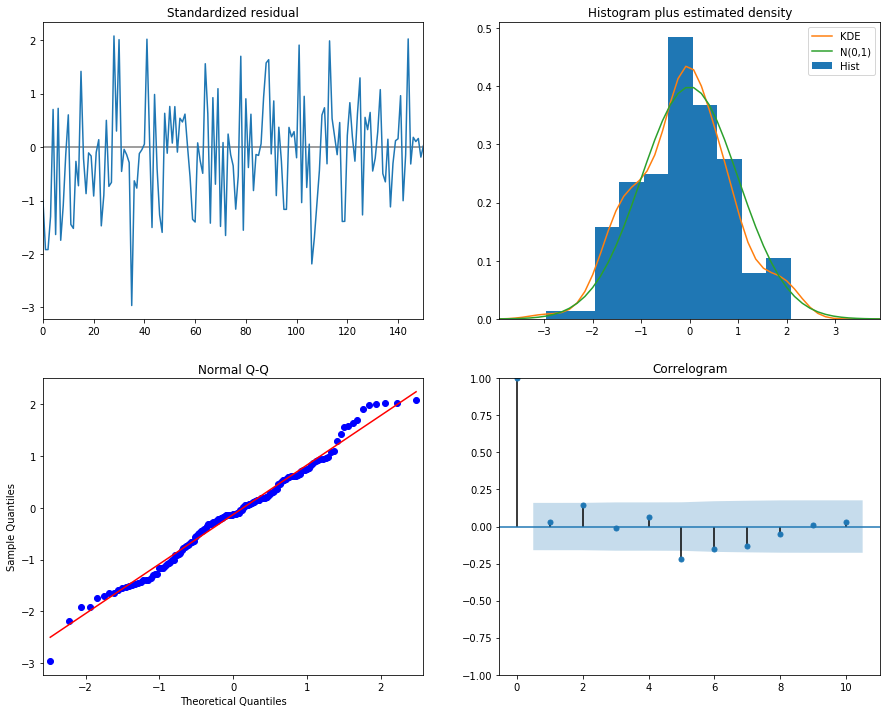

In [12]:
results_1.plot_diagnostics(figsize=(15, 12))
plt.show()

In [13]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 3)
SARIMAX: (0, 0, 1) x (0, 0, 2, 3)
SARIMAX: (0, 0, 2) x (0, 1, 0, 3)
SARIMAX: (0, 0, 2) x (0, 1, 1, 3)


In [14]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-36],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 3)3 - AIC:3851.613209476687
ARIMA(0, 0, 0)x(0, 0, 1, 3)3 - AIC:3692.5317028317995
ARIMA(0, 0, 0)x(0, 0, 2, 3)3 - AIC:3581.4935656198886
ARIMA(0, 0, 0)x(0, 1, 0, 3)3 - AIC:3264.0169127882673
ARIMA(0, 0, 0)x(0, 1, 1, 3)3 - AIC:3118.4530050740905
ARIMA(0, 0, 0)x(0, 1, 2, 3)3 - AIC:3027.7114695950295
ARIMA(0, 0, 0)x(0, 2, 0, 3)3 - AIC:3413.267758294547
ARIMA(0, 0, 0)x(0, 2, 1, 3)3 - AIC:3237.5617726930836
ARIMA(0, 0, 0)x(0, 2, 2, 3)3 - AIC:3154.677738214399
ARIMA(0, 0, 0)x(1, 0, 0, 3)3 - AIC:3284.3450159622307
ARIMA(0, 0, 0)x(1, 0, 1, 3)3 - AIC:3196.6717394625616
ARIMA(0, 0, 0)x(1, 0, 2, 3)3 - AIC:3101.6692951287937
ARIMA(0, 0, 0)x(1, 1, 0, 3)3 - AIC:2954.3939178397814
ARIMA(0, 0, 0)x(1, 1, 1, 3)3 - AIC:2904.9838238614775
ARIMA(0, 0, 0)x(1, 1, 2, 3)3 - AIC:2804.0163784046135
ARIMA(0, 0, 0)x(1, 2, 0, 3)3 - AIC:2997.8059768526787
ARIMA(0, 0, 0)x(1, 2, 1, 3)3 - AIC:2977.384054281316
ARIMA(0, 0, 0)x(1, 2, 2, 3)3 - AIC:2850.696020069013
ARIMA(0, 0, 0)x(2, 0, 0, 3)3 - AI

ARIMA(0, 1, 2)x(2, 0, 1, 3)3 - AIC:2780.626317722001
ARIMA(0, 1, 2)x(2, 0, 2, 3)3 - AIC:2746.187025015122
ARIMA(0, 1, 2)x(2, 1, 0, 3)3 - AIC:2841.7596353908675
ARIMA(0, 1, 2)x(2, 1, 1, 3)3 - AIC:2874.6252328241785
ARIMA(0, 1, 2)x(2, 1, 2, 3)3 - AIC:2867.361849031422
ARIMA(0, 1, 2)x(2, 2, 0, 3)3 - AIC:2873.1478547315705
ARIMA(0, 1, 2)x(2, 2, 1, 3)3 - AIC:2899.1313167804665
ARIMA(0, 1, 2)x(2, 2, 2, 3)3 - AIC:3088.3033299320296
ARIMA(0, 2, 0)x(0, 0, 0, 3)3 - AIC:3133.965749544752
ARIMA(0, 2, 0)x(0, 0, 1, 3)3 - AIC:3046.08999880677
ARIMA(0, 2, 0)x(0, 0, 2, 3)3 - AIC:2980.0225828601024
ARIMA(0, 2, 0)x(0, 1, 0, 3)3 - AIC:3256.759726153654
ARIMA(0, 2, 0)x(0, 1, 1, 3)3 - AIC:3098.7054666613103
ARIMA(0, 2, 0)x(0, 1, 2, 3)3 - AIC:2962.877630920546
ARIMA(0, 2, 0)x(0, 2, 0, 3)3 - AIC:3398.1446149944454
ARIMA(0, 2, 0)x(0, 2, 1, 3)3 - AIC:3219.595308181778
ARIMA(0, 2, 0)x(0, 2, 2, 3)3 - AIC:3134.5996120988866
ARIMA(0, 2, 0)x(1, 0, 0, 3)3 - AIC:3039.624582919727
ARIMA(0, 2, 0)x(1, 0, 1, 3)3 - AIC:297

ARIMA(1, 0, 2)x(1, 0, 0, 3)3 - AIC:2966.0043242521424
ARIMA(1, 0, 2)x(1, 0, 1, 3)3 - AIC:2995.599093955242
ARIMA(1, 0, 2)x(1, 0, 2, 3)3 - AIC:2854.5797080637612
ARIMA(1, 0, 2)x(1, 1, 0, 3)3 - AIC:2872.6798305148454
ARIMA(1, 0, 2)x(1, 1, 1, 3)3 - AIC:2912.262846256065
ARIMA(1, 0, 2)x(1, 1, 2, 3)3 - AIC:2890.679864509114
ARIMA(1, 0, 2)x(1, 2, 0, 3)3 - AIC:3168.0483322012174
ARIMA(1, 0, 2)x(1, 2, 1, 3)3 - AIC:2827.294997438779
ARIMA(1, 0, 2)x(1, 2, 2, 3)3 - AIC:3065.8160696284576
ARIMA(1, 0, 2)x(2, 0, 0, 3)3 - AIC:2870.583737757307
ARIMA(1, 0, 2)x(2, 0, 1, 3)3 - AIC:2899.6818063104906
ARIMA(1, 0, 2)x(2, 0, 2, 3)3 - AIC:2861.6011357517314
ARIMA(1, 0, 2)x(2, 1, 0, 3)3 - AIC:2801.9336541377525
ARIMA(1, 0, 2)x(2, 1, 1, 3)3 - AIC:2938.3508339379987
ARIMA(1, 0, 2)x(2, 1, 2, 3)3 - AIC:2932.988101148226
ARIMA(1, 0, 2)x(2, 2, 0, 3)3 - AIC:2853.152800070356
ARIMA(1, 0, 2)x(2, 2, 1, 3)3 - AIC:2809.5806656062923
ARIMA(1, 0, 2)x(2, 2, 2, 3)3 - AIC:3067.6754353767365
ARIMA(1, 1, 0)x(0, 0, 0, 3)3 - AIC:

ARIMA(1, 2, 2)x(0, 0, 1, 3)3 - AIC:2927.716868812383
ARIMA(1, 2, 2)x(0, 0, 2, 3)3 - AIC:2842.268338797793
ARIMA(1, 2, 2)x(0, 1, 0, 3)3 - AIC:3162.222465159279
ARIMA(1, 2, 2)x(0, 1, 1, 3)3 - AIC:3026.14473787685
ARIMA(1, 2, 2)x(0, 1, 2, 3)3 - AIC:2848.5931377065335
ARIMA(1, 2, 2)x(0, 2, 0, 3)3 - AIC:3299.7995651255987
ARIMA(1, 2, 2)x(0, 2, 1, 3)3 - AIC:3164.9739812715306
ARIMA(1, 2, 2)x(0, 2, 2, 3)3 - AIC:3083.5785277410855
ARIMA(1, 2, 2)x(1, 0, 0, 3)3 - AIC:2897.7394245781097
ARIMA(1, 2, 2)x(1, 0, 1, 3)3 - AIC:2841.0050367968443
ARIMA(1, 2, 2)x(1, 0, 2, 3)3 - AIC:2780.579110725894
ARIMA(1, 2, 2)x(1, 1, 0, 3)3 - AIC:3039.0554782158315
ARIMA(1, 2, 2)x(1, 1, 1, 3)3 - AIC:2998.929119847926
ARIMA(1, 2, 2)x(1, 1, 2, 3)3 - AIC:2935.958176722379
ARIMA(1, 2, 2)x(1, 2, 0, 3)3 - AIC:3081.100975347428
ARIMA(1, 2, 2)x(1, 2, 1, 3)3 - AIC:3137.2544001317615
ARIMA(1, 2, 2)x(1, 2, 2, 3)3 - AIC:3075.3053290036096
ARIMA(1, 2, 2)x(2, 0, 0, 3)3 - AIC:2842.141947900782
ARIMA(1, 2, 2)x(2, 0, 1, 3)3 - AIC:277

ARIMA(2, 1, 1)x(2, 0, 2, 3)3 - AIC:2764.2740901438956
ARIMA(2, 1, 1)x(2, 1, 0, 3)3 - AIC:2789.200732177873
ARIMA(2, 1, 1)x(2, 1, 1, 3)3 - AIC:2777.9615497783466
ARIMA(2, 1, 1)x(2, 1, 2, 3)3 - AIC:2754.168104432748
ARIMA(2, 1, 1)x(2, 2, 0, 3)3 - AIC:2831.18182784566
ARIMA(2, 1, 1)x(2, 2, 1, 3)3 - AIC:2769.165545094117
ARIMA(2, 1, 1)x(2, 2, 2, 3)3 - AIC:2787.6328740535128
ARIMA(2, 1, 2)x(0, 0, 0, 3)3 - AIC:2893.6370829526313
ARIMA(2, 1, 2)x(0, 0, 1, 3)3 - AIC:2813.6635093313043
ARIMA(2, 1, 2)x(0, 0, 2, 3)3 - AIC:2753.9973754676357
ARIMA(2, 1, 2)x(0, 1, 0, 3)3 - AIC:2965.3597335532513
ARIMA(2, 1, 2)x(0, 1, 1, 3)3 - AIC:2883.444847299368
ARIMA(2, 1, 2)x(0, 1, 2, 3)3 - AIC:2826.6706739998453
ARIMA(2, 1, 2)x(0, 2, 0, 3)3 - AIC:3092.215405430797
ARIMA(2, 1, 2)x(0, 2, 1, 3)3 - AIC:3010.266476230942
ARIMA(2, 1, 2)x(0, 2, 2, 3)3 - AIC:2941.7745001621074
ARIMA(2, 1, 2)x(1, 0, 0, 3)3 - AIC:2829.7416116251043
ARIMA(2, 1, 2)x(1, 0, 1, 3)3 - AIC:2792.537458482473
ARIMA(2, 1, 2)x(1, 0, 2, 3)3 - AIC:27

Оптимальные значения ARIMA(1, 1, 2)x(1, 0, 2, 3)

In [17]:
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-36],order=[1,1,2],
                                seasonal_order=[1,0,2,3] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2716.242374844398


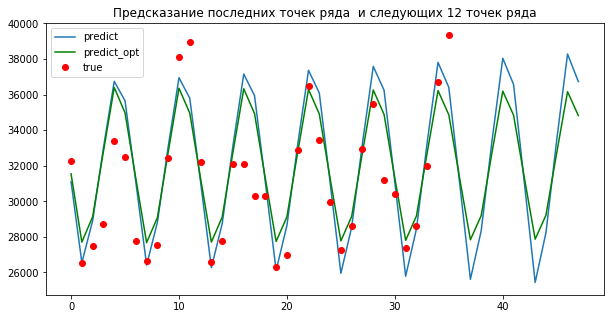

In [22]:
pred_dynamic = results_1.forecast(48)
pred_dynamic_opt = results_opt.forecast(48)

plt.figure(figsize =(10,5))
plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-36:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()

plt.show()

Предсказываем на год вперед на основании всех данных, тестовый период три года по месячному ресемплингу. По сравнению с недельным ресемплингом, критерий AIC получился гораздо нижн, значит, наша модель построена более качественно.